In [36]:
from game import Game
import numpy as np
from model import ModelRLMC
from action import Action
from state import State
import racetrack_list as rlist
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import random
random.seed(42)

In [14]:
def get_reward_of_episode(episode: list[tuple[State, Action, int]]):
    total_reward = 0
    for i, (state, action, reward) in enumerate(episode):
        total_reward += reward
    return total_reward

In [69]:
track = rlist.get_track1()
game = Game(racetrack=track, visualize=False)

train_times = np.zeros(10)
# dimensions: n_model, n_game, n_steps, reward
stats_per_game_and_model: list[tuple[int, int, int, int]] = []

for i in range(10):
    model = ModelRLMC()
    start = time.time()
    for j in range(0, 3000):
        episode: list[tuple[State, Action, int]] = []
        n_steps = 0
        while not game.is_finished() and n_steps < 1000:
            state = game.get_state()
            action = model.determine_action(state)
            reward = game.step(action)
            episode.append((state, action, reward))
            n_steps += 1
        model.learn(episode)
        game.reset()

        total_reward = get_reward_of_episode(episode)
        stats_per_game_and_model.append((i,j,n_steps,total_reward))
    end = time.time()
    train_times[i] = end - start

In [74]:
print(f"train time: {train_times.mean():2.4f} ± {train_times.std():2.4f}")

train time: 4.7071 ± 0.6820


In [75]:
stats_df = pd.DataFrame(stats_per_game_and_model, columns=["n_model","n_games","n_steps","reward"])

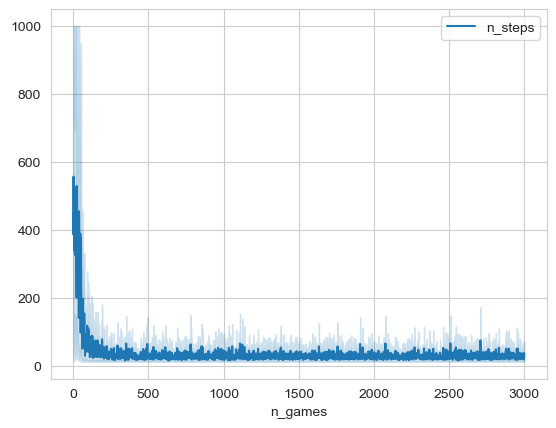

In [76]:
stats_grouped = stats_df.groupby(["n_games"]).aggregate({'n_steps':['mean','min','max']})
sns.lineplot(stats_grouped);

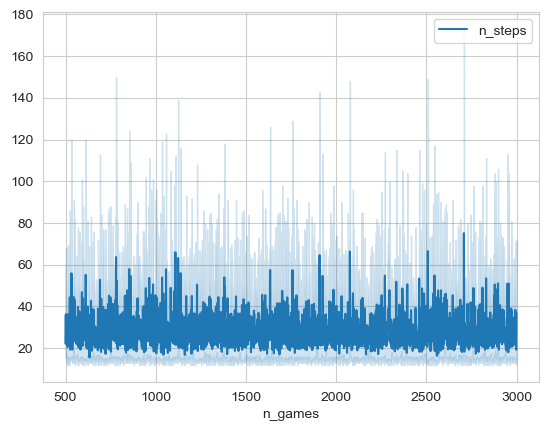

In [77]:
sns.lineplot(stats_grouped[stats_grouped.index >= 500]);

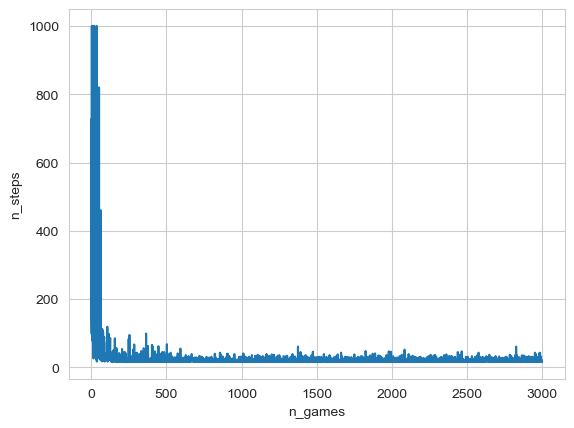

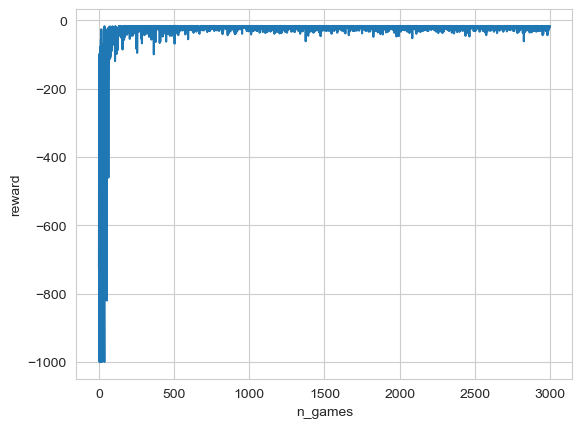

In [78]:
stats_model0_df = stats_df[stats_df["n_model"] == 0]
sns.lineplot(stats_model0_df, x="n_games",y="n_steps");
plt.show()
sns.lineplot(stats_model0_df, x="n_games",y="reward");